## Import Libraries


In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB1,EfficientNetB0,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,EfficientNetB6,EfficientNetB7
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

## classify labels

In [40]:
labels = ['CONTROL', 'AD', 'PD']

## loading Dataset

In [41]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 61/61 [00:00<00:00, 406.37it/s]


In [42]:
X_train.shape

(7839, 150, 150, 3)

In [43]:
Y_train.shape

(7839,)

In [69]:
X_train,Y_train=shuffle(X_train,Y_train,random_state=101)

## train test split

In [70]:
Xtrain,xtest, Ytrain,ytest=train_test_split(X_train,Y_train,test_size=0.2,random_state=101)

In [71]:
Xtrain.shape

(6271, 150, 150, 3)

In [72]:
ytest.shape

(1568,)

## One hot Encoding

In [73]:
y_train_new = []
y_test_new = []

for i in Ytrain:
    y_train_new.append(labels.index(i))
ytrain = to_categorical(y_train_new) 

for i in ytest:
    y_test_new.append(labels.index(i))

ytest = to_categorical(y_test_new)

In [74]:
ytrain.shape

(6271, 3)

In [75]:
ytest.shape

(1568, 3)

In [76]:
xtrain=Xtrain

In [77]:
xtrain.shape

(6271, 150, 150, 3)

## Callded Model

In [78]:
efficientnet_B0 = EfficientNetB0(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

## Generate model Outlate

In [79]:
# Output of model
model = efficientnet_B0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)

In [80]:
model = tf.keras.models.Model(inputs=efficientnet_B0.input, outputs=model)



In [81]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 150, 150, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 150, 150, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [83]:
model.compile( optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
             )

## To overcome Model Overfitting, use these items

In [84]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficient_net_B0.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)

2022-09-17 06:39:00.836853: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-17 06:39:00.837034: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-17 06:39:01.032736: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-17 06:39:01.032948: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [85]:
history = model.fit(xtrain,ytrain,
                    batch_size=32,
                    validation_split=0.2,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
  1/157 [..............................] - ETA: 36:34 - loss: 1.3239 - accuracy: 0.2812

2022-09-17 06:39:22.207928: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-17 06:39:22.207982: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/157 [..............................] - ETA: 1:09 - loss: 1.0837 - accuracy: 0.4688 

2022-09-17 06:39:23.351305: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-17 06:39:23.356625: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-17 06:39:23.511090: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2105 callback api events and 2102 activity events. 
2022-09-17 06:39:23.566726: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-17 06:39:23.633294: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_17_06_39_23

2022-09-17 06:39:23.671148: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.trace.json.gz


  3/157 [..............................] - ETA: 2:26 - loss: 0.9945 - accuracy: 0.5521

2022-09-17 06:39:23.777483: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_17_06_39_23

2022-09-17 06:39:23.786668: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.memory_profile.json.gz
2022-09-17 06:39:23.791568: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_09_17_06_39_23
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2022_09_17_06_39_23/8a5c0a9b6814.tensorflow_stats.

157/157 [==============================] - 37s 146ms/step - loss: 0.6119 - accuracy: 0.6982 - val_loss: 2.8553 - val_accuracy: 0.4892
Epoch 2/20
157/157 [==============================] - 19s 122ms/step - loss: 0.3830 - accuracy: 0.8331 - val_loss: 0.6213 - val_accuracy: 0.7538
Epoch 3/20
157/157 [==============================] - 19s 123ms/step - loss: 0.2460 - accuracy: 0.8993 - val_loss: 1.0905 - val_accuracy: 0.7131
Epoch 4/20
157/157 [==============================] - 19s 124ms/step - loss: 0.1598 - accuracy: 0.9370 - val_loss: 0.1732 - val_accuracy: 0.9331
Epoch 5/20
157/157 [==============================] - 19s 123ms/step - loss: 0.1175 - accuracy: 0.9541 - val_loss: 0.2180 - val_accuracy: 0.9251
Epoch 6/20
157/157 [==============================] - 19s 121ms/step - loss: 0.0976 - accuracy: 0.9615 - val_loss: 0.2736 - val_accuracy: 0.8988
Epoch 7/20
157/157 [==============================] - 19s 124ms/step - loss: 0.0708 - accuracy: 0.9759 - val_loss: 0.2737 - val_accuracy: 0.9

In [86]:
pred = model.predict(xtest)


In [87]:
score=model.evaluate(xtest,ytest)
print("Loss: ",score[0],"Accuracy: ",score[1])

49/49 [==============================] - 2s 24ms/step - loss: 0.3247 - accuracy: 0.9407
Loss:  0.32471975684165955 Accuracy:  0.9406887888908386


In [88]:
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       720
           1       0.94      0.99      0.96       642
           2       0.84      0.98      0.90       206

    accuracy                           0.94      1568
   macro avg       0.92      0.95      0.93      1568
weighted avg       0.94      0.94      0.94      1568



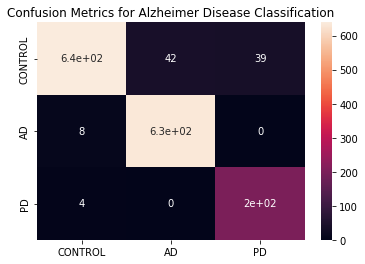

In [89]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

## Loss and Accuracy Measurement graph

In [90]:
def accuracy_and_loss_Plot(modelData):
    
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

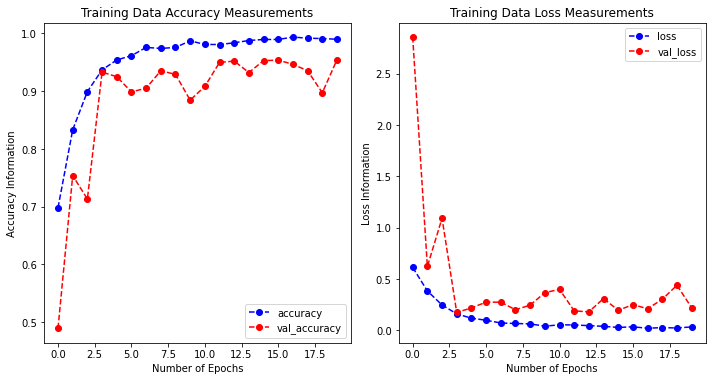

In [91]:
accuracy_and_loss_Plot(history)

In [92]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "CONTROL"
    elif prd == 1:
        prd = "AD"
    elif prd ==2:
        prd = "PD"
        
    print(f'Model Predict That is  a {prd}')

In [93]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [94]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])